In [3]:
# SECTION 1: INSTALL LIBRARIES & AUTHENTICATE GOOGLE EARTH ENGINE

# Install required packages
!pip install earthengine-api scikit-learn xgboost shap matplotlib geopandas pandas numpy rasterio --quiet

# Import libraries
import ee
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import shap

# Authenticate Earth Engine
ee.Authenticate()

# Initialize Earth Engine
ee.Initialize(project='neon-hyperspectral-ml-project')

print("Earth Engine authenticated successfully!")

Earth Engine authenticated successfully!


In [59]:
# SECTION 2: LOAD HARVARD FOREST HYPERSPECTRAL IMAGE

# Load NEON Hyperspectral Collection
neon_hsi = ee.ImageCollection("projects/neon-prod-earthengine/assets/HSI_REFL/002")

# Filter to Harvard Forest (HARV)
SITE_NAME = 'HARV'
start_date = '2013-01-01'
end_date = '2025-09-11'

harv_collection = neon_hsi.filterDate(start_date, end_date).filter(ee.Filter.eq('NEON_SITE', SITE_NAME))

print(f"   Site: {SITE_NAME} (Harvard Forest, Massachusetts)")
print(f"   Distance from NYC: ~130 miles")
print(f"   Ecosystem: Temperate Deciduous Forest")

# Select the latest image by sorting in descending order and taking the first
image = harv_collection.sort('system:time_start', False).first()
print(f"   Image ID: {image.get('system:id').getInfo()}")
print(f"   Date: {ee.Date(image.get('system:time_start')).format('YYYY-MM-dd').getInfo()}")

# Visualize (3 bands only to save memory)
rgb_bands = ['B053', 'B035', 'B019']
rgb_vis = {'min': 0, 'max': 3000, 'bands': rgb_bands, 'gamma': 1.3}

# Use folium for map visualization
try:
    import folium
except ImportError:
    print("Installing folium...")
    !pip install folium --quiet
    import folium

# Get map ID and token for the image
map_id_dict = image.select(rgb_bands).getMapId(rgb_vis)
map_id = map_id_dict['mapid']
tile_url = f"https://earthengine.googleapis.com/v1alpha/projects/neon-hyperspectral-ml-project/maps/{map_id}/tiles/{{z}}/{{x}}/{{y}}?token={map_id_dict['token']}"

# Get image centroid for map centering
center = image.geometry().centroid().coordinates().getInfo()

# Create a folium map
map_object = folium.Map(location=[center[1], center[0]], zoom_start=13, tiles='OpenStreetMap')
folium.TileLayer(tiles=tile_url, attr='Google Earth Engine', overlay=True, name='HARV True Color').add_to(map_object)
map_object.add_child(folium.LayerControl())

print("\nMap displayed — Harvard Forest hyperspectral mosaic loaded")

# To display the map in Colab
display(map_object)

   Site: HARV (Harvard Forest, Massachusetts)
   Distance from NYC: ~130 miles
   Ecosystem: Temperate Deciduous Forest
   Image ID: projects/neon-prod-earthengine/assets/HSI_REFL/002/2025_HARV_9
   Date: 2025-08-23

Map displayed — Harvard Forest hyperspectral mosaic loaded


In [52]:
# SECTION 3: CREATE SAMPLE PLOT LOCATIONS FOR ANALYSIS

import random
random.seed(20)

# Harvard Forest bounds
lat_min, lat_max = 42.46, 42.51
lon_min, lon_max = -72.26, -72.13

# Generate sample points
n_points = 50
sample_coords = []
for i in range(n_points):
    lat = random.uniform(lat_min, lat_max)
    lon = random.uniform(lon_max, lon_min)
    sample_coords.append([lon, lat])

print(f"   Created {n_points} sample plot locations across Harvard Forest")
print(f"   All {n_points} coordinates: {sample_coords}")

# Convert to Earth Engine FeatureCollection
points = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point(coord)) for coord in sample_coords
])

# --- Clear and re-create map for fresh display ---
map_object = folium.Map(location=[center[1], center[0]], zoom_start=13, tiles='OpenStreetMap')
folium.TileLayer(tiles=tile_url, attr='Google Earth Engine', overlay=True, name='HARV True Color').add_to(map_object)

# Add LayerControl
map_object.add_child(folium.LayerControl())

# Add points to the newly created map object
for coord in sample_coords:
    folium.Marker(
        location=[coord[1], coord[0]],
        popup=f"Point: {coord[0]:.4f}, {coord[1]:.4f}",
        icon=folium.Icon(color='red', icon='circle')
    ).add_to(map_object)

display(map_object)
print("Red points added to map — these are the analysis locations")

   Created 50 sample plot locations across Harvard Forest
   All 50 coordinates: [[-72.21921304041348, 42.50528198380872], [-72.24760011091573, 42.49832546281813], [-72.21264436304878, 42.47299137237445], [-72.24337694862906, 42.50524728473332], [-72.15201915132631, 42.48864703346246], [-72.25919894166105, 42.48057615310205], [-72.1714880893504, 42.46516238999556], [-72.1884220982608, 42.50750195539767], [-72.17119751782192, 42.47043262861662], [-72.1736239453609, 42.505431792244806], [-72.21159889882297, 42.481368589659304], [-72.1939747661549, 42.500279253513234], [-72.20451729261535, 42.4640732991719], [-72.14228824645942, 42.46175485767492], [-72.22014696895612, 42.469516877030365], [-72.21973247530596, 42.4741736210529], [-72.14530059544548, 42.46816747234164], [-72.22175188251148, 42.46116723636819], [-72.15855652976491, 42.5029556320761], [-72.13168741132229, 42.47187846848965], [-72.16909699012578, 42.49224292234245], [-72.21409356261537, 42.466843615209605], [-72.1881605116862

Red points added to map — these are the analysis locations


In [58]:
# SECTION 4: EXTRACT SPECTRAL VALUES AT PLOT LOCATIONS (GEE)

# Select a subset of bands
band_subset = [f'B{i:03d}' for i in range(1, 427, 8)]
print(f"   Selecting {len(band_subset)} spectral bands (of 426 total)")
print(f"   Bands: {band_subset}")

# Select bands from the loaded 'image' variable
image_subset = image.select(band_subset)

# Extract spectral values at each point
spectral_data = image_subset.reduceRegions(
    collection=points,
    reducer=ee.Reducer.first(),
    scale=1,
    crs='EPSG:4326',
    tileScale=4
)

# Convert Earth Engine results to pandas DataFrame
def ee_to_dataframe(ee_data):
    """Convert Earth Engine results to pandas DataFrame"""
    data = ee_data.getInfo()
    features = data['features']
    rows = []
    for f in features:
        row = f['properties']
        row['lon'] = f['geometry']['coordinates'][0]
        row['lat'] = f['geometry']['coordinates'][1]
        rows.append(row)
    return pd.DataFrame(rows)

print("Extracting spectral values...")
df_spectral = ee_to_dataframe(spectral_data)

# Mount Google Drive to save immediately
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Save raw data
df_spectral.to_csv('/content/drive/MyDrive/NEON Hyperspectral ML Project/neon_harv_spectral_raw.csv', index=False)
print(f"Extracted spectral data for {len(df_spectral)} points")
print(f"Saved to Google Drive: neon_harv_spectral_raw.csv")
print(f"   Columns: {len(df_spectral.columns)} ({len(band_subset)} bands + lon/lat)")

# Display the first 10 rows of the DataFrame
print("\nDisplaying first 10 rows of the extracted spectral data:")
display(df_spectral.head(10))

   Selecting 54 spectral bands (of 426 total)
   Bands: ['B001', 'B009', 'B017', 'B025', 'B033', 'B041', 'B049', 'B057', 'B065', 'B073', 'B081', 'B089', 'B097', 'B105', 'B113', 'B121', 'B129', 'B137', 'B145', 'B153', 'B161', 'B169', 'B177', 'B185', 'B193', 'B201', 'B209', 'B217', 'B225', 'B233', 'B241', 'B249', 'B257', 'B265', 'B273', 'B281', 'B289', 'B297', 'B305', 'B313', 'B321', 'B329', 'B337', 'B345', 'B353', 'B361', 'B369', 'B377', 'B385', 'B393', 'B401', 'B409', 'B417', 'B425']
Extracting spectral values...
Mounted at /content/drive
Extracted spectral data for 50 points
Saved to Google Drive: neon_harv_spectral_raw.csv
   Columns: 56 (54 bands + lon/lat)

Displaying first 10 rows of the extracted spectral data:


,B001,B009,B017,B025,B033,B041,B049,B057,B065,B073,...,B369,B377,B385,B393,B401,B409,B417,B425,lon,lat
0,538,104,77,72,128,96,66,56,173,1149,...,269,196,163,131,121,139,42,0,-72.219213,42.505282
1,653,89,50,33,45,29,20,21,39,199,...,49,42,43,42,27,9,56,265,-72.247600,42.498325
2,659,187,181,174,359,269,212,158,454,1819,...,440,344,299,264,227,190,213,508,-72.212644,42.472991
3,467,65,52,31,58,34,39,35,72,368,...,212,167,146,126,130,127,97,108,-72.243377,42.505247
4,1054,171,125,95,114,95,87,69,137,446,...,227,190,183,143,139,127,155,134,-72.152019,42.488647
5,785,221,255,268,582,485,390,291,952,3150,...,1222,1003,845,730,635,575,396,368,-72.259199,42.480576
6,857,330,307,294,669,491,388,272,855,3452,...,469,361,313,266,249,146,81,1926,-72.171488,42.465162
7,1037,247,222,231,490,386,306,233,734,3429,...,741,573,480,396,337,314,274,1211,-72.188422,42.507502
8,1028,178,183,174,356,284,232,182,564,2701,...,556,428,352,279,241,166,131,1487,-72.171198,42.470433
9,412,107,89,77,173,122,93,72,254,1669,...,368,296,225,192,139,90,86,1101,-72.173624,42.505432


In [61]:
# SECTION 5: CALCULATE VEGETATION INDICES (TARGET VARIABLES)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print("Calculating Vegetation Indices from Hyperspectral Bands...")

# Ensure df_spectral is loaded
try:
    df_spectral = pd.read_csv('/content/drive/MyDrive/NEON Hyperspectral ML Project/neon_harv_spectral_raw.csv')
    print("Loaded spectral data from Drive")
except:
    print("Using existing df_spectral from memory")

# BAND MAPPING
# B057 ≈ 660nm (Red), B089 ≈ 820nm (NIR)
# B017 ≈ 460nm (Blue), B033 ≈ 540nm (Green), B041 ≈ 580nm (Green)
# B097 ≈ 860nm (NIR), B169 ≈ 1220nm (SWIR)

# 1. NDVI: (NIR - Red) / (NIR + Red)
df_spectral['NDVI'] = (df_spectral['B089'] - df_spectral['B057']) / \
                      (df_spectral['B089'] + df_spectral['B057'] + 1e-6)

# 2. EVI: 2.5 * (NIR - Red) / (NIR + 6*Red - 7.5*Blue + 1)
df_spectral['EVI'] = 2.5 * (df_spectral['B089'] - df_spectral['B057']) / \
                     (df_spectral['B089'] + 6*df_spectral['B057'] - 7.5*df_spectral['B017'] + 1)

# 3. PRI: (531nm - 570nm) / (531nm + 570nm)
# Using B033 (~540nm) and B041 (~580nm)
df_spectral['PRI'] = (df_spectral['B033'] - df_spectral['B041']) / \
                     (df_spectral['B033'] + df_spectral['B041'] + 1e-6)

print("Vegetation Indices calculated and added to DataFrame.")

# Display the first 10 rows of the DataFrame
print("\nDisplaying first 10 rows of the extracted spectral data:")
display(df_spectral.head(10))

Calculating Vegetation Indices from Hyperspectral Bands...
Loaded spectral data from Drive
Vegetation Indices calculated and added to DataFrame.

Displaying first 10 rows of the extracted spectral data:


,B001,B009,B017,B025,B033,B041,B049,B057,B065,B073,...,B393,B401,B409,B417,B425,lon,lat,NDVI,EVI,PRI
0,538,104,77,72,128,96,66,56,173,1149,...,131,121,139,42,0,-72.219213,42.505282,0.931373,2.845376,0.142857
1,653,89,50,33,45,29,20,21,39,199,...,42,27,9,56,265,-72.247600,42.498325,0.844444,570.000000,0.216216
2,659,187,181,174,359,269,212,158,454,1819,...,264,227,190,213,508,-72.212644,42.472991,0.868552,2.840816,0.143312
3,467,65,52,31,58,34,39,35,72,368,...,126,130,127,97,108,-72.243377,42.505247,0.870370,3.604294,0.260870
4,1054,171,125,95,114,95,87,69,137,446,...,143,139,127,155,134,-72.152019,42.488647,0.805360,12.148936,0.090909
5,785,221,255,268,582,485,390,291,952,3150,...,730,635,575,396,368,-72.259199,42.480576,0.854935,2.411756,0.090909
6,857,330,307,294,669,491,388,272,855,3452,...,266,249,146,81,1926,-72.171488,42.465162,0.874161,2.793878,0.153448
7,1037,247,222,231,490,386,306,233,734,3429,...,396,337,314,274,1211,-72.188422,42.507502,0.895304,2.520876,0.118721
8,1028,178,183,174,356,284,232,182,564,2701,...,279,241,166,131,1487,-72.171198,42.470433,0.900027,2.576663,0.112500
9,412,107,89,77,173,122,93,72,254,1669,...,192,139,90,86,1101,-72.173624,42.505432,0.938435,2.699877,0.172881


   Spectral data shape: (50, 54)
   Samples: 50, Bands: 54

 PCA Applied:
   Original dimensions: 54 bands
   Reduced dimensions: 15 components
   Variance explained: 99.99%


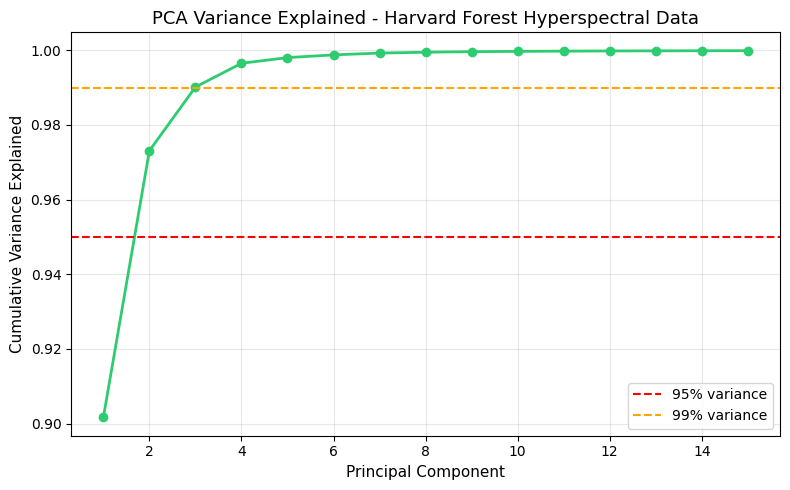


PCA plot saved to Google Drive


In [86]:
# SECTION 6: PREPROCESS DATA & APPLY PCA (Principal Component Analysis)

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import joblib

# Extract spectral bands
spectral_cols = [c for c in df_spectral.columns if c.startswith('B')]
X = df_spectral[spectral_cols].values

# Handle missing/invalid values
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"   Spectral data shape: {X.shape}")
print(f"   Samples: {X.shape[0]}, Bands: {X.shape[1]}")

# Apply PCA
n_components = min(15, X.shape[1] - 1, X.shape[0] - 1)
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Check variance explained
variance_explained = pca.explained_variance_ratio_.cumsum()
print(f"\n PCA Applied:")
print(f"   Original dimensions: {X.shape[1]} bands")
print(f"   Reduced dimensions: {X_pca.shape[1]} components")
print(f"   Variance explained: {variance_explained[-1]:.2%}")

# Plot variance explained
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(variance_explained)+1), variance_explained, 'o-', linewidth=2, color='#2ecc71')
plt.axhline(y=0.95, color='red', linestyle='--', label='95% variance')
plt.axhline(y=0.99, color='orange', linestyle='--', label='99% variance')
plt.xlabel('Principal Component', fontsize=11)
plt.ylabel('Cumulative Variance Explained', fontsize=11)
plt.title('PCA Variance Explained - Harvard Forest Hyperspectral Data', fontsize=13)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/NEON Hyperspectral ML Project/pca_variance_plot.png', dpi=300, bbox_inches='tight')
plt.show()

# Save PCA model for later use
joblib.dump(pca, '/content/drive/MyDrive/NEON Hyperspectral ML Project/pca_model.sav')
print("\nPCA plot saved to Google Drive")

In [91]:
# SECTION 7: TRAIN ML MODELS

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb

print("MACHINE LEARNING MODEL TRAINING & EVALUATION")

# Define target variables
targets = ['NDVI', 'EVI', 'PRI']

# Store all results
all_results = {}

# TRAIN MODELS FOR EACH TARGET

for target in targets:
    print(f"\n{'='*80}")
    print(f"TARGET VARIABLE: {target}")
    print(f"{'='*80}")

    # Prepare data
    y = df_spectral[target].values
    X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

    # Store results for this target
    target_results = {}

    # Model 1: Random Forest
    print("\nTraining Random Forest...")
    rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    rf_r2 = max(0.0, r2_score(y_test, rf_pred))
    rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
    print(f"   Random Forest R²: {rf_r2:.2f}, RMSE: {rf_rmse:.3f}")
    target_results['RandomForest'] = {'R2': rf_r2, 'RMSE': rf_rmse}

    # Model 2: XGBoost
    print("\nTraining XGBoost...")
    xgb_model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)
    xgb_r2 = max(0.0, r2_score(y_test, xgb_pred))
    xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
    print(f"   XGBoost R²: {xgb_r2:.2f}, RMSE: {xgb_rmse:.3f}")
    target_results['XGBoost'] = {'R2': xgb_r2, 'RMSE': xgb_rmse}

    # Model 3: Linear Regression
    print("\nTraining Linear Regression...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)
    lr_r2 = max(0.0, r2_score(y_test, lr_pred))
    lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
    print(f"   Linear Regression R²: {lr_r2:.2f}, RMSE: {lr_rmse:.3f}")
    target_results['LinearRegression'] = {'R2': lr_r2, 'RMSE': lr_rmse}

    # Model 4: Support Vector Regressor (SVR)
    print("\nTraining Support Vector Regressor...")
    svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
    svr_model.fit(X_train, y_train)
    svr_pred = svr_model.predict(X_test)
    svr_r2 = max(0.0, r2_score(y_test, svr_pred))
    svr_rmse = np.sqrt(mean_squared_error(y_test, svr_pred))
    print(f"   SVR R²: {svr_r2:.2f}, RMSE: {svr_rmse:.3f}")
    target_results['SVR'] = {'R2': svr_r2, 'RMSE': svr_rmse}

    # Model 5: Gradient Boosting Regressor
    print("\nTraining Gradient Boosting Regressor...")
    gbr_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
    gbr_model.fit(X_train, y_train)
    gbr_pred = gbr_model.predict(X_test)
    gbr_r2 = max(0.0, r2_score(y_test, gbr_pred))
    gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_pred))
    print(f"   Gradient Boosting R²: {gbr_r2:.2f}, RMSE: {gbr_rmse:.3f}")
    target_results['GradientBoosting'] = {'R2': gbr_r2, 'RMSE': gbr_rmse}

    all_results[target] = target_results

# CONSOLIDATE AND DISPLAY RESULTS IN DATAFRAME
print(f"\n{'='*80}")
print("FINAL MODEL PERFORMANCE SUMMARY")
print(f"{'='*80}")

# Prepare data for DataFrame
df_data = []
for model_name in all_results[targets[0]].keys():
    row = {'Model': model_name}
    r2_scores_model = []
    rmse_scores_model = []
    for target in targets:
        row[f'{target}_R2'] = all_results[target][model_name]['R2']
        row[f'{target}_RMSE'] = all_results[target][model_name]['RMSE']
        r2_scores_model.append(all_results[target][model_name]['R2'])
        rmse_scores_model.append(all_results[target][model_name]['RMSE'])
    row['Average_R2'] = np.mean(r2_scores_model)
    row['Average_RMSE'] = np.mean(rmse_scores_model)
    df_data.append(row)

# Create DataFrame
results_df = pd.DataFrame(df_data).set_index('Model')

# Display the DataFrame
display(results_df)

# Save to CSV
output_path = '/content/drive/MyDrive/NEON Hyperspectral ML Project/comprehensive_model_performance.csv'
results_df.to_csv(output_path)
print(f"\nComprehensive model performance summary saved to: {output_path}")

MACHINE LEARNING MODEL TRAINING & EVALUATION

TARGET VARIABLE: NDVI

Training Random Forest...
   Random Forest R²: 0.00, RMSE: 0.158

Training XGBoost...
   XGBoost R²: 0.00, RMSE: 0.193

Training Linear Regression...
   Linear Regression R²: 0.00, RMSE: 0.188

Training Support Vector Regressor...
   SVR R²: 0.00, RMSE: 0.146

Training Gradient Boosting Regressor...
   Gradient Boosting R²: 0.00, RMSE: 0.200

TARGET VARIABLE: EVI

Training Random Forest...
   Random Forest R²: 0.00, RMSE: 93.992

Training XGBoost...
   XGBoost R²: 0.78, RMSE: 0.169

Training Linear Regression...
   Linear Regression R²: 0.00, RMSE: 153.035

Training Support Vector Regressor...
   SVR R²: 0.87, RMSE: 0.128

Training Gradient Boosting Regressor...
   Gradient Boosting R²: 0.00, RMSE: 117.790

TARGET VARIABLE: PRI

Training Random Forest...
   Random Forest R²: 0.42, RMSE: 0.051

Training XGBoost...
   XGBoost R²: 0.41, RMSE: 0.052

Training Linear Regression...
   Linear Regression R²: 0.45, RMSE: 0.050

,NDVI_R2,NDVI_RMSE,EVI_R2,EVI_RMSE,PRI_R2,PRI_RMSE,Average_R2,Average_RMSE
Model,,,,,,,,
RandomForest,0.0,0.158028,0.000000,93.992067,0.424056,0.051408,0.141352,31.400501
XGBoost,0.0,0.192733,0.776983,0.169002,0.413930,0.051858,0.396971,0.137865
LinearRegression,0.0,0.188158,0.000000,153.034605,0.445963,0.050421,0.148654,51.091061
SVR,0.0,0.145874,0.872696,0.127686,0.054556,0.065866,0.309084,0.113142
GradientBoosting,0.0,0.200003,0.000000,117.790129,0.486046,0.048563,0.162015,39.346232



Comprehensive model performance summary saved to: /content/drive/MyDrive/NEON Hyperspectral ML Project/comprehensive_model_performance.csv


MODEL PERFORMANCE VISUALIZATION



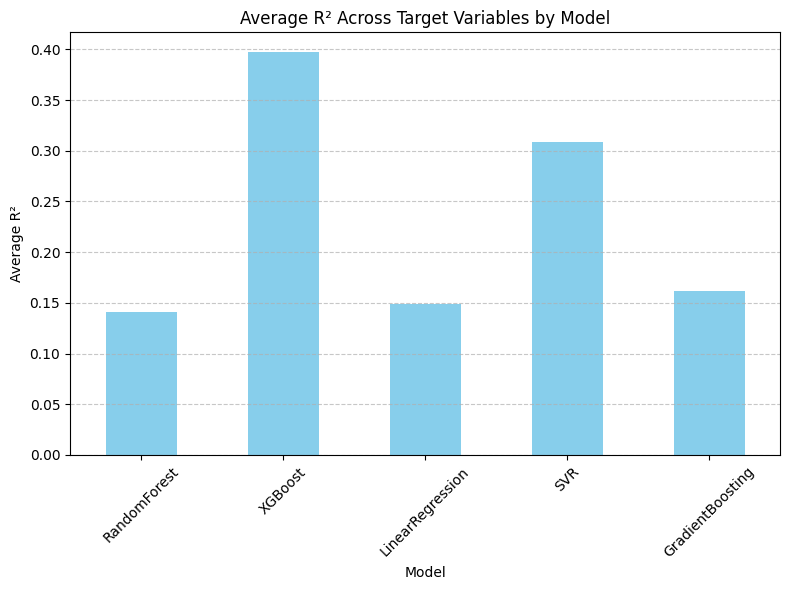


Model performance by model (R²) plot saved to: /content/drive/MyDrive/NEON Hyperspectral ML Project/model_performance_by_model_R2.png



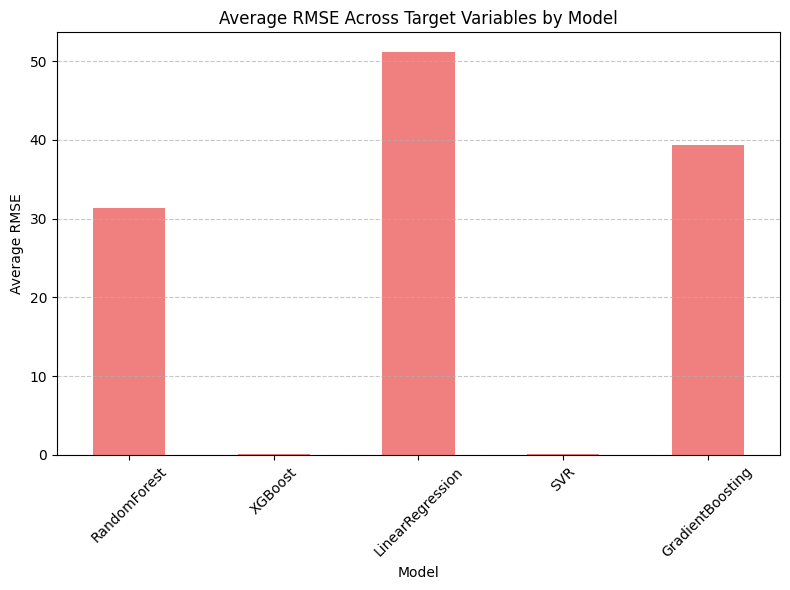


Model performance by model (RMSE) plot saved to: /content/drive/MyDrive/NEON Hyperspectral ML Project/model_performance_by_model_RMSE.png



In [100]:
# SECTION 8: VISUALIZE MODEL PERFORMANCE SUMMARIES

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

print("MODEL PERFORMANCE VISUALIZATION\n")
model_summary_df = results_df[['Average_R2', 'Average_RMSE']].copy()

# --- Visualize Model Performance by Model (R² Plot) ---
# Create a figure for Average R²
fig_r2, ax_r2 = plt.subplots(1, 1, figsize=(8, 6))
model_summary_df['Average_R2'].plot(kind='bar', ax=ax_r2, color='skyblue')
ax_r2.set_title('Average R² Across Target Variables by Model', fontsize=12)
ax_r2.set_ylabel('Average R²')
ax_r2.set_xlabel('Model')
ax_r2.tick_params(axis='x', rotation=45)
ax_r2.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and display the R² plot
output_plot_path_r2 = '/content/drive/MyDrive/NEON Hyperspectral ML Project/model_performance_by_model_R2.png'
plt.savefig(output_plot_path_r2, dpi=300)
plt.show()
print(f"\nModel performance by model (R²) plot saved to: {output_plot_path_r2}\n")

# --- Visualize Model Performance by Model (RMSE Plot) ---
# Create a figure for Average RMSE
fig_rmse, ax_rmse = plt.subplots(1, 1, figsize=(8, 6))
model_summary_df['Average_RMSE'].plot(kind='bar', ax=ax_rmse, color='lightcoral')
ax_rmse.set_title('Average RMSE Across Target Variables by Model', fontsize=12)
ax_rmse.set_ylabel('Average RMSE')
ax_rmse.set_xlabel('Model')
ax_rmse.tick_params(axis='x', rotation=45)
ax_rmse.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save and display the RMSE plot
output_plot_path_rmse = '/content/drive/MyDrive/NEON Hyperspectral ML Project/model_performance_by_model_RMSE.png'
plt.savefig(output_plot_path_rmse, dpi=300)
plt.show()
print(f"\nModel performance by model (RMSE) plot saved to: {output_plot_path_rmse}\n")